In [1]:
import pandas as pd
from pathlib import Path
from collections import Counter
import re
from corpus_processing import PROCESSED_DATA_PATH, PROCESSED_DATA_PATH_PICKLE
import matplotlib.pyplot as plt

In [2]:
ONLY_WORDS_AND_DIGITS_REGEX = re.compile(r'[\w\dא-ת]+')
def get_only_words_and_digits(text: str):
    return ONLY_WORDS_AND_DIGITS_REGEX.findall(text)

def text_to_word_list(text: str):
    return get_only_words_and_digits(text)
    #return text.split()

def invert_words(words: list):
    return [w[::-1] for w in words]

In [3]:
def words_count(texts: pd.Series):
    texts_split = pd.Series((text_to_word_list(text) for text in texts))

    return texts_split.map(lambda x: len(x)).hist()

In [4]:
def most_common_words(texts: pd.Series, n: int, stopwords: list = None):
    if stopwords is None:
	    stopwords = []
    words_counter = Counter()
    for text in texts:
        for word in text_to_word_list(text):
            if word not in stopwords:
                words_counter[word] += 1
    sorted_word_count = sorted(words_counter.items(), key=lambda x:x[1], reverse=True)
    with open("word_count_all_text.txt", 'w', encoding='utf-8') as f:
        for item in sorted_word_count:
            f.write(item[0] + " : " + str(item[1]))
            f.write("\n")
    words, count = zip(*sorted_word_count[:n])
    words = invert_words(words)
    fig = plt.figure(figsize=(15,10))
    return plt.bar(words, count)


<BarContainer object of 20 artists>

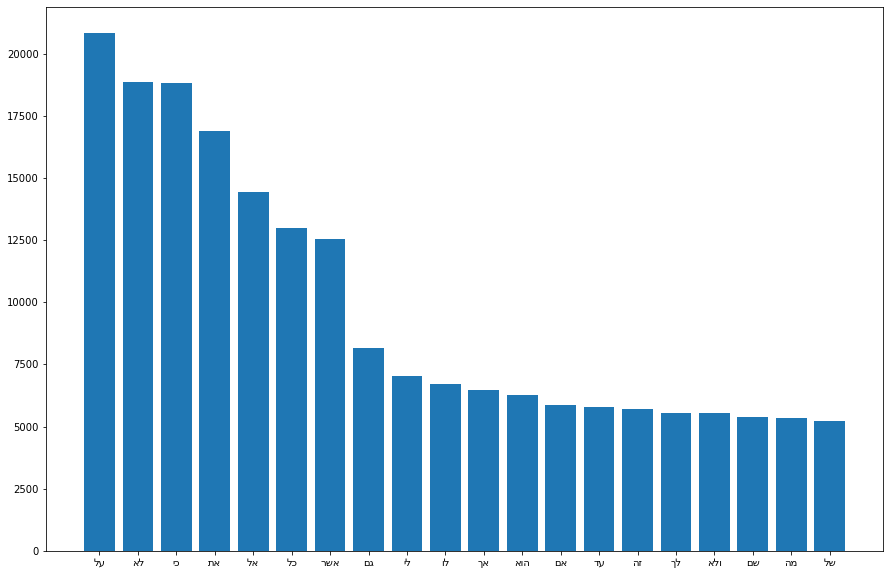

In [5]:
#df = pd.read_csv(PROCESSED_DATA_PATH)
df = pd.read_pickle(PROCESSED_DATA_PATH_PICKLE)

most_common_words(df.content, 20)

In [6]:
def plot_word_number_histogram(text: pd.Series):
    return text.map(lambda x: len(text_to_word_list(x))).hist(bins=50)

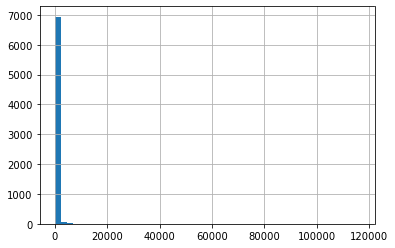

In [7]:
plot_word_number_histogram(df.content)
df['words_count'] = df.content.map(lambda x: len(text_to_word_list(x)))
df.to_csv("words_count.csv", columns=["ID","title","authors","genre","words_count"])

In [11]:
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
import pyLDAvis.gensim

def get_lda_objects(text, num_of_topics=6):

    def _preprocess_text(text):
        corpus=[]
        lem=WordNetLemmatizer()
        for news in text:
            words= text_to_word_list(news)

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus

    corpus=_preprocess_text(text)

    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]

    lda_model =  gensim.models.LdaMulticore(bow_corpus,
                                   num_topics = num_of_topics,
                                   id2word = dic,
                                   passes = 10,
                                   workers = 2)

    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
    return vis

C:\ProgramData\Anaconda3\envs\final_project\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
lda_model, bow_corpus, dic = get_lda_objects(df.content)
lda_model.show_topics()

[(0,
  '0.008*"אשר" + 0.004*"הוא" + 0.004*"אני" + 0.003*"עלי" + 0.003*"ולא" + 0.002*"עוד" + 0.002*"פני" + 0.002*"בין" + 0.002*"אדם" + 0.002*"בני"'),
 (1,
  '0.007*"אשר" + 0.004*"ולא" + 0.004*"ככה" + 0.004*"אתה" + 0.004*"בני" + 0.003*"הוא" + 0.003*"איש" + 0.002*"יען" + 0.002*"אני" + 0.002*"אולם"'),
 (2,
  '0.007*"אשר" + 0.005*"ולא" + 0.004*"הוא" + 0.003*"עוד" + 0.002*"איש" + 0.002*"אין" + 0.002*"עלי" + 0.002*"אמר" + 0.002*"כמו" + 0.002*"אני"'),
 (3,
  '0.010*"אשר" + 0.005*"הוא" + 0.004*"ולא" + 0.003*"יום" + 0.003*"אין" + 0.003*"עלי" + 0.003*"עוד" + 0.003*"אני" + 0.002*"איש" + 0.002*"ויאמר"'),
 (4,
  '0.006*"אשר" + 0.005*"עוד" + 0.004*"אין" + 0.004*"הוא" + 0.003*"היא" + 0.002*"בין" + 0.002*"אני" + 0.002*"יום" + 0.002*"איש" + 0.002*"ולא"'),
 (5,
  '0.007*"אשר" + 0.004*"עלי" + 0.003*"הוא" + 0.002*"יום" + 0.002*"ולא" + 0.002*"עוד" + 0.002*"אין" + 0.002*"היא" + 0.001*"אתה" + 0.001*"כמו"')]

In [13]:
plot_lda_vis(lda_model, bow_corpus, dic)

C:\ProgramData\Anaconda3\envs\final_project\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.019053 -0.010879       1        1  31.274306
4      0.008429  0.099966       2        1  24.876149
1      0.140094 -0.036178       3        1  16.507848
2     -0.027340  0.000299       4        1  12.630601
0     -0.038629  0.026036       5        1   9.558504
5     -0.063503 -0.079244       6        1   5.152592, topic_info=         Term          Freq         Total Category  logprob  loglift
664       אשר  11672.000000  11672.000000  Default  30.0000  30.0000
846       עלי   3127.000000   3127.000000  Default  29.0000  29.0000
1328      ככה   1383.000000   1383.000000  Default  28.0000  28.0000
77619  אודיסס    501.000000    501.000000  Default  27.0000  27.0000
14191   האלים    640.000000    640.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
250      שלום     64.469423    892.015757   Topic6  -7.0643   0.3384
626       פני     79.621948   2300.393112   Topic6  -6.8532  -0.3979
259       בית     71.190891   1436.208745   Topic6  -6.9651  -0.0387
1851      בני     78.432213   2674.753326   Topic6  -6.8683  -0.5637
309       לבי     73.046496   1813.987954   Topic6  -6.9394  -0.2465

[538 rows x 6 columns], token_table=        Topic      Freq     Term
term                            
153396      4  0.975981     ____
138810      1  0.914469      the
138810      5  0.030482      the
138810      6  0.045723      the
5898        1  0.221796      אבו
...       ...       ...      ...
36374       3  0.085123     תעבד
36374       6  0.468176     תעבד
91073       1  0.933320   תקבלנה
14158       5  0.890982  תקלליני
7841        1  0.981992    תתברך

[1285 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 2, 3, 1, 6])